In [1]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv('Concrete_Data.csv')

# rename columns
df.rename(columns=lambda x: x.split('(')[0].strip(), inplace=True)

### Standardization 

In [2]:
from sklearn.preprocessing import StandardScaler

np_scaled = StandardScaler().fit_transform(df)
df = pd.DataFrame(np_scaled, columns=df.columns)
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,0.863154,-1.217670,-0.279733,2.645408
1,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,1.056164,-1.217670,-0.279733,1.561421
2,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,3.553066,0.266627
3,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677,0.313340
4,-0.790459,0.678408,-0.847144,0.488793,-1.039143,0.070527,0.647884,4.978487,0.507979


### Visualization

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

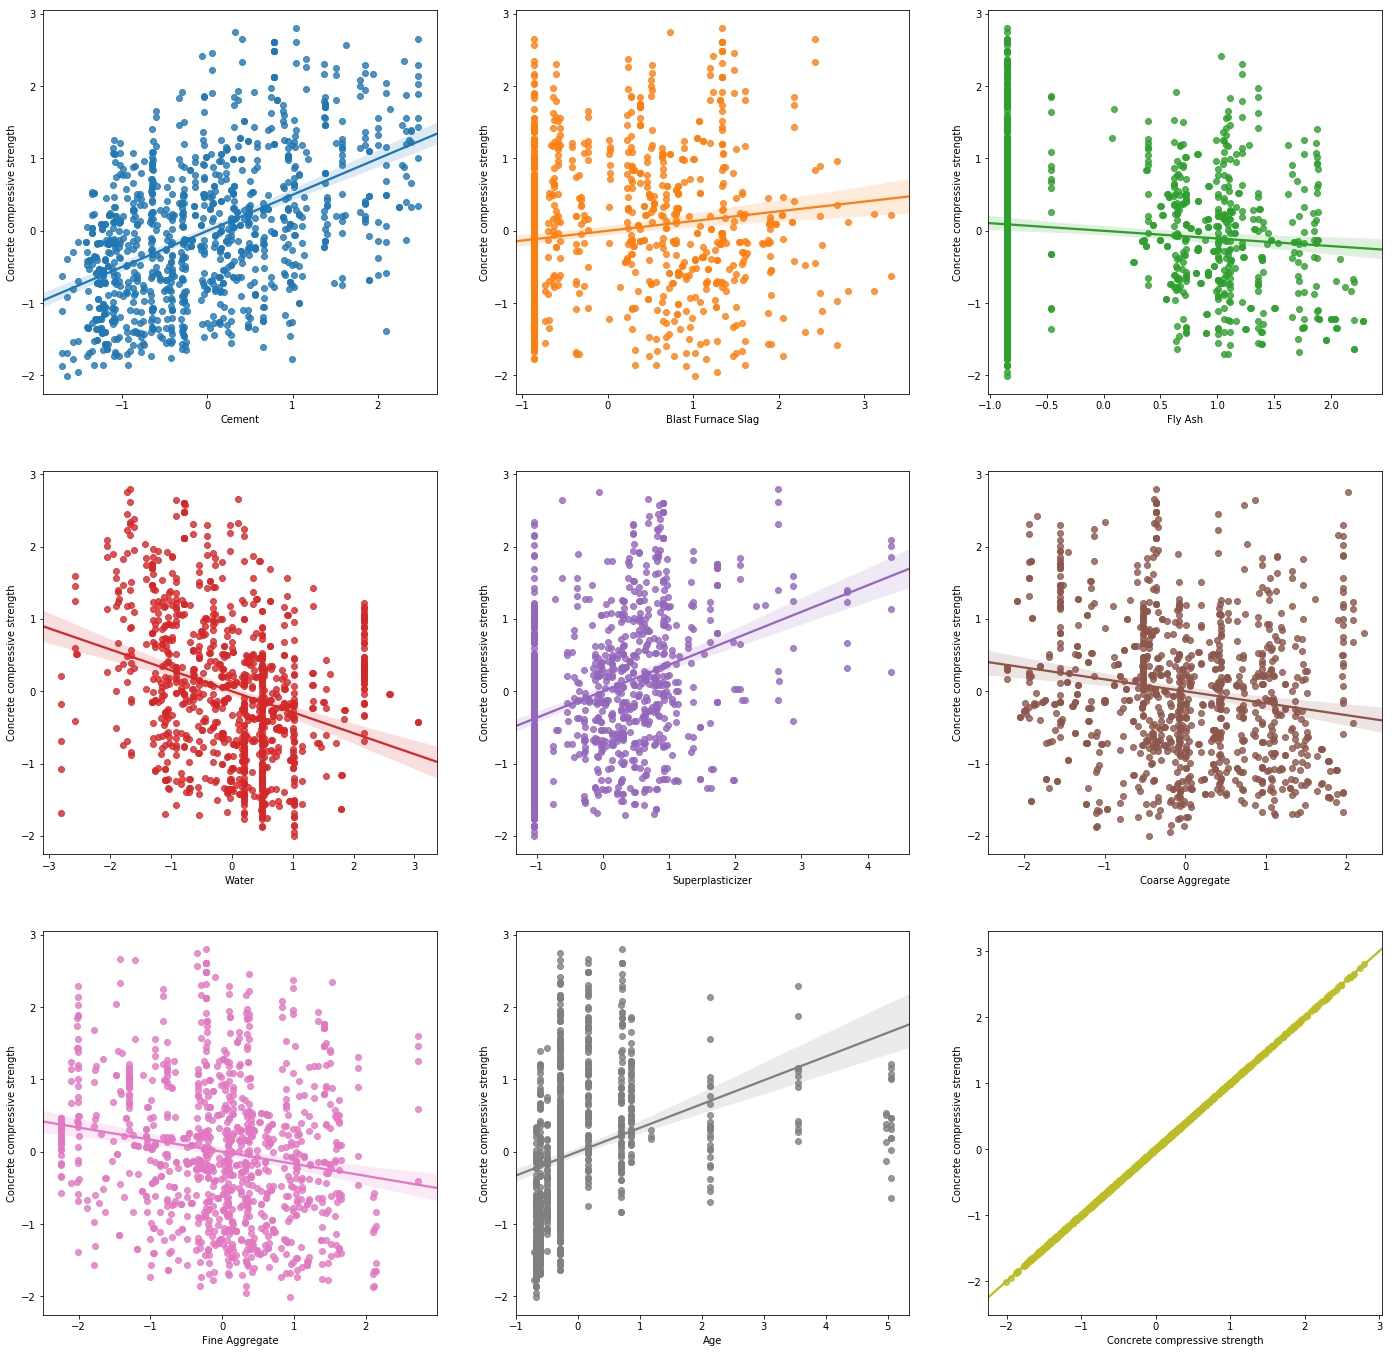

In [4]:
# Create a figure instance, and the two subplots
inputNum = 8

axes = []
fig, axes = plt.subplots(3, 3, figsize=(24, 24))

for i in range(0, 3):
    for j in range(0, 3):
        sns.regplot(x=df.columns[i*3+j], y=df.columns[inputNum], data=df, ax=axes[i][j])

plt.show()

### Training

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

inputNum = 8

X, y = df.iloc[:, 0:inputNum], df.iloc[:, inputNum:inputNum+1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
wName = ['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']
trainMSE = []
trainR2 = []

def descent3(X, y, dimension, w_current, learning_rate):
    w_gradient = np.zeros(dimension)
    N = float(X.shape[0])
    for i in range(0, X.shape[0]):
        x_data = X.iloc[i]
        y_data = y.iloc[i]
        #Calculating predicted value of model
        predicted = w_current[0]
        for j in range(1, X.shape[1]+1):
            predicted += w_current[j]*x_data[j-1]
        #Error value by model
        error = y_data[0] - predicted
        
        #Accumulating gradient from each 
        w_gradient[0] += -(2/N) * error
        for j in range(1, X.shape[1]+1):
            w_gradient[j] += -(2/N) * error * x_data[j-1]
    step_size = w_gradient * learning_rate
    new_w = w_current - step_size
    return new_w, step_size


def gd3(X, y, dimension, learning_rate=0.01, epochs=3000, stopThreshold = 0.000001):
    w_cur = np.random.uniform(-0.5,0.5,dimension)
    
    for i in range(epochs):
        w_cur, stepsize = descent3(X, y, dimension, w_cur, learning_rate)
        #y_pred_temp = y.copy.drop(index)
        
        Xcopy = X.copy()
        for j in range(dimension-1):
            Xcopy.iloc[:, j] *= w_cur[j+1]    
        y_pred_temp = Xcopy.sum(axis=1) + w_cur[0]
        
        mse = mean_squared_error(y, y_pred_temp)
        r2 = r2_score(y, y_pred_temp)
        
        trainMSE.append(mse)
        trainR2.append(r2)
        #print('w_cur:\n', w_cur, '\n----------\n')
        #print('step:\n', step, '\n----------\n')
        if all(abs(stepsize) < stopThreshold):
            print('prev_grad:\n', stepsize, '\n----------\n')
            print("epoch: ", i)
            break
    return w_cur

In [7]:
# use 8 attributes to train 
w_finish = gd3(X_train.iloc[:, 0:1], y_train, 2)

prev_grad:
 [-8.69107868e-08 -9.82915764e-07] 
----------

epoch:  455


In [8]:
w_finish = pd.DataFrame(w_finish.reshape((1,2)), columns=wName[:2])
w_finish

,w0,w1
0,0.006024,0.498177


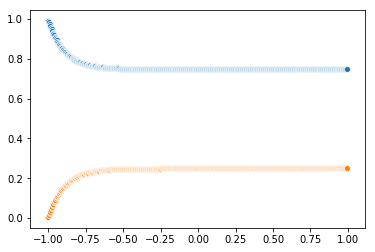

In [9]:
T = np.linspace(-1, max(trainMSE), len(trainMSE))
sns.scatterplot(x=T, y=trainMSE)
sns.scatterplot(x=T, y=trainR2)

### Prediction 

In [10]:
X_test2=X_test.iloc[:, 0:2].copy()

In [11]:
# w1X1, w2X2, ... , w8X8
for i in range(1):
    X_test2.iloc[:, i] *= w_finish.iloc[0, i+1]

In [12]:
# fit test data to our gd model

# (w1X1 + w2X2 + ... + w8X8) + w0
y_pred_gd3 = X_test2.sum(axis=1) + w_finish.iloc[0, 0]


#row = ['lm1', 'lm2', 'lm3', 'lm4', 'lm5', 'lm6', 'lm7', 'lm8']
col = ['MSE', 'Cor', 'R2', 'bias', 'weight']
regResult = pd.DataFrame(columns=col)
regResult.loc['gd3'] = mean_squared_error(y_test, y_pred_gd3), 0, r2_score(y_test, y_pred_gd3), \
                        w_finish.iloc[0, 0],  np.array(w_finish.iloc[0, 1:2])

In [13]:
regResult

,MSE,Cor,R2,bias,weight
gd3,1.333941,0,-0.320367,0.006024,[0.49817691875915754]


In [15]:
import numpy as np
from sklearn import linear_model
clf = linear_model.SGDRegressor(max_iter=1000, tol=0.000001)
clf.fit(X_train.iloc[:,0:1], y_train)

y_pred_sgd = clf.predict(X_test.iloc[:,0:1])

print('Coefficients (weight): ', clf.coef_)
print('\nIntercept (bias): ', clf.intercept_)
print('SGD R2-score: ', r2_score(y_test, y_pred_sgd))


Coefficients (weight):  [0.49691347]

Intercept (bias):  [0.00193101]
SGD R2-score:  0.24018350482306505


/home/phua/anaconda3/envs/machine_learning/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
